In [1]:
%cd ..

/data/marciano/experiments/multi-organ-qc/moqc


In [2]:
%cd ..

/data/marciano/experiments/multi-organ-qc


In [3]:
import monai
from monai.transforms.compose import Compose
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    ResizeWithPadOrCropd,
    CenterSpatialCropd,
)

from monai.apps import DecathlonDataset
from monai.data import DataLoader, PatchDataset, create_test_image_3d

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
plt.rcParams["figure.figsize"] = 12, 8
monai.utils.set_determinism()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
root_dir = "MSD_data"

In [6]:
transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys="image"),
        RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# available options are: ['Task01_BrainTumour', 'Task02_Heart', 
# 'Task03_Liver', 'Task04_Hippocampus', 'Task05_Prostate', 'Task06_Lung', 
# 'Task07_Pancreas', 'Task08_HepaticVessel', 'Task09_Spleen', 'Task10_Colon']
volume_ds = DecathlonDataset(
    root_dir=root_dir, task="Task04_Hippocampus", transform=transforms, section="training", seed=12345, download=False
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
Loading dataset:   0%|          | 0/208 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 208/208 [00:00<00:00, 233.45it/s]


In [7]:
check_loader = DataLoader(volume_ds, batch_size=1, pin_memory=torch.cuda.is_available(), num_workers=8)
check_data = monai.utils.misc.first(check_loader)
print("first volume's shape: ", check_data["image"].shape, check_data["label"].shape)

first volume's shape:  torch.Size([1, 1, 40, 48, 34]) torch.Size([1, 1, 40, 48, 34])


In [8]:
import numpy as np
np.unique(check_data["label"])

array([0., 1., 2.], dtype=float32)

In [9]:
num_samples = 4
patch_func = monai.transforms.RandSpatialCropSamplesd(
    keys=["image", "label"],
    roi_size=[-1, -1, 1],  # dynamic spatial_size for the first two dimensions
    num_samples=num_samples,
    random_size=False,
)

patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[256, 256]),
        # to use crop/pad instead of resize:
        #ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[256, 256], mode="replicate"),
        
    ]
)
patch_ds = PatchDataset(
    volume_ds,
    transform=patch_transform,
    patch_func=patch_func,
    samples_per_image=num_samples,
)
train_loader = DataLoader(
    patch_ds,
    batch_size=8,
    shuffle=True,  # this shuffles slices from different volumes
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
)

check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["image"].shape, check_data["label"].shape)

first patch's shape:  torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


In [10]:
for i, batch in enumerate(train_loader): 
    if len(np.unique(batch["label"])) > 2: 
        print("more than 2 classes in the label", np.unique(batch["label"]), i)

more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 0
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 1
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 2
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 3
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 4
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 5
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.25 1.5  2.  ] 6
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 7
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.25 1.5  2.  ] 8
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 9
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 10
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.25 1.5  2.  ] 11
more than 2 classes in the label [0.   0.25 0.5  0.75 1.   1.5  2.  ] 12
more than 2 classes in the label [0.   0.25 0.

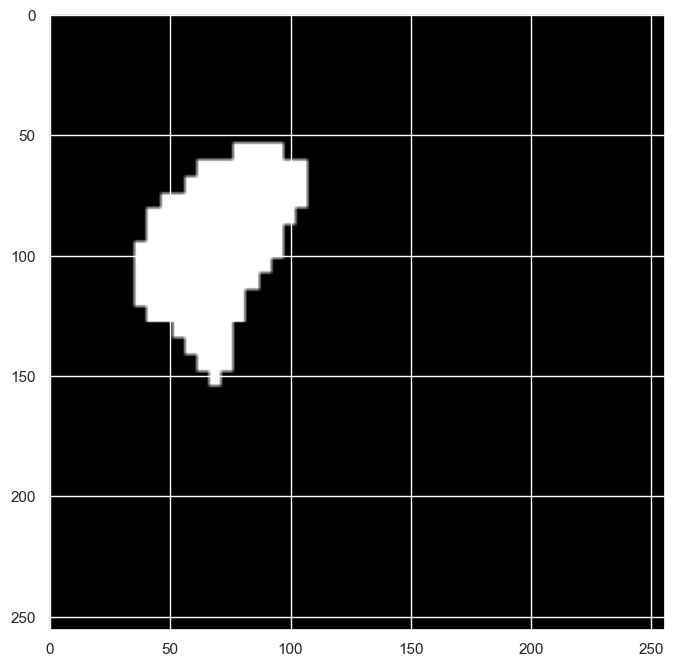

In [11]:
plt.imshow(check_data["label"][6].squeeze(), cmap="gray")
plt.show()

In [12]:
unet = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=3,
    channels=(32, 32, 64, 64, 128, 128, 512),
    strides=(2, 1, 2, 1, 2, 1)
).to(device)

swin_net = monai.networks.nets.SwinUNETR(
    img_size=(256,256), 
    in_channels=1, 
    out_channels=3, 
    use_checkpoint=True, 
    spatial_dims=2
).to(device)

In [13]:
loss_DC = monai.losses.DiceLoss(softmax=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-4, weight_decay=1e-5)

epoch_loss_values = []
num_epochs = 100
for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    unet.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), np.round(batch_data["label"].cpu().numpy())
        optimizer.zero_grad()
        labels = F.one_hot(torch.tensor(labels).to(device).long(), num_classes=3).squeeze().transpose(1, 3)
        outputs = swin_net(inputs).to(device)
        loss = loss_DC(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(patch_ds) // train_loader.batch_size
        if step % 25 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print("train completed")

----------
epoch 1/100
25/104, train_loss: 0.7864
50/104, train_loss: 0.8072
75/104, train_loss: 0.8008
100/104, train_loss: 0.7856
epoch 1 average loss: 0.7906
----------
epoch 2/100
25/104, train_loss: 0.7783
50/104, train_loss: 0.7930
75/104, train_loss: 0.7843
100/104, train_loss: 0.7894
epoch 2 average loss: 0.7904
----------
epoch 3/100
25/104, train_loss: 0.7978
50/104, train_loss: 0.8034
75/104, train_loss: 0.8062
100/104, train_loss: 0.7866
epoch 3 average loss: 0.7906
----------
epoch 4/100
25/104, train_loss: 0.7941
50/104, train_loss: 0.8014
75/104, train_loss: 0.7935
100/104, train_loss: 0.7856
epoch 4 average loss: 0.7919
----------
epoch 5/100
25/104, train_loss: 0.7866
50/104, train_loss: 0.7904
75/104, train_loss: 0.8020
100/104, train_loss: 0.7851
epoch 5 average loss: 0.7929
----------
epoch 6/100
25/104, train_loss: 0.7790
50/104, train_loss: 0.8007
75/104, train_loss: 0.7897
100/104, train_loss: 0.7843
epoch 6 average loss: 0.7915
----------
epoch 7/100
25/104, tra

KeyboardInterrupt: 

In [ ]:
from monai.metrics import DiceMetric
from monai.visualize import matshow3d
from monai.inferers import SliceInferer


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task09_Spleen", transform=val_transforms, section="validation", seed=12345, download=False
)

data_loader = DataLoader(val_ds, num_workers=8, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
unet.eval()
with torch.no_grad():
    for val_data in data_loader:
        val_images = val_data["image"].to(device)
        roi_size = (256, 256)
        sw_batch_size = 8
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            spatial_dim=1,  # Spatial dim to slice along is defined here
            device=torch.device("cpu"),
            padding_mode="replicate",
        )
        val_output = slice_inferer(val_images, unet).cpu()
        dice_metric(y_pred=val_output > 0.5, y=val_data["label"])
        print("Dice: ", dice_metric.get_buffer()[-1][0])
        #fig = plt.figure(figsize=(10, 4))
        #plt.subplot(1, 2, 1)
        #matshow3d(val_output[0].squeeze(), fig=plt.gca())
        #plt.subplot(1, 2, 2)
        #matshow3d(val_images[0].squeeze(), fig=plt.gca())
        #plt.show()
    print(f"Avg Dice: {dice_metric.aggregate().item()}")

In [ ]:
val_output[0].squeeze().size()

In [ ]:
plt.imshow(val_data['label'][0].squeeze()[:,:,20])

In [ ]:
volume = val_output[0].squeeze().permute(2, 0, 1).to('cpu').detach().numpy()
volume.shape

In [ ]:
r, c = volume[0].shape

# Define frames
import numpy as np
from skimage import io
import plotly.graph_objects as go
nb_frames = volume.shape[0]

fig = go.Figure(frames=[go.Frame(data=go.Surface(
    z=(nb_frames*.1 - k * 0.1) * np.ones((r, c)),
    surfacecolor=np.flipud(volume[(nb_frames-1) - k]),
    cmin=0, cmax=200
    ),
    name=str(k) # you need to name the frame for the animation to behave properly
    )
    for k in range(nb_frames)])

# Add data to be displayed before animation starts
fig.add_trace(go.Surface(
    z=nb_frames*.1 * np.ones((r, c)),
    surfacecolor=np.flipud(volume[(nb_frames-1)]),
    colorscale='Gray',
    cmin=0, cmax=200,
    colorbar=dict(thickness=20, ticklen=4)
    ))


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Layout
fig.update_layout(
         title='Slices in volumetric data',
         width=600,
         height=600,
         scene=dict(
                    zaxis=dict(range=[-0.1, nb_frames*.1], autorange=False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(100)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()

In [ ]:
def extract_2d_slices_from(data):
    images = []
    labels = []
    for i in range(len(data)):
        image = data[i]['image']
        label = data[i]['label']
        try:
            images = torch.cat((images, torch.Tensor(image).unsqueeze(dim=0))) if len(images) else torch.Tensor(image).unsqueeze(dim=0)
            labels = torch.cat((labels, torch.Tensor(label))) if len(labels) else torch.Tensor(label)
        except: print("Different dimensions: ", image.size(), label.size(), ". Skipping image.")
    return images, labels

In [ ]:
import torchio
import os

def save_for_ae(loader, model, threshold, dir):
    count = 0
    seg_path, gt_path = os.path.join(dir, 'measures/segmentations'), os.path.join(dir, 'labels')
    if not os.path.exists(os.path.join(dir, 'measures')):  os.makedirs(seg_path)
    if not os.path.exists(os.path.join(dir, 'labels')): os.makedirs(gt_path) 
    for i, batch in enumerate(loader):
        w, h = batch['label'][0].size()[0], batch['label'][0].size()[1]
        model.to(device)
        model.eval()
        with torch.no_grad():
            output_image = model(batch["image"].to(device))
            output_image = torchio.ScalarImage(tensor=output_image.cpu().numpy())
        
        # check if  pixels are non zero
        if torch.count_nonzero(batch['label'][0]).item() > threshold:
            count +=1 
            label_image = torchio.ScalarImage(tensor=batch['label'].cpu().numpy())
            output_image.save(os.path.join(seg_path, f'patient_{i:03d}.nii.gz'))
            label_image.save(os.path.join(gt_path, f'segmentation_{i:03d}.nii.gz'))
    print(f"Successfully saved {count} images to ", dir)

In [ ]:
loader = DataLoader(
    patch_ds,
    batch_size=1,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
)
save_for_ae(loader, unet, .005, 'data/prostate')

In [ ]:
import nibabel as nib

img = nib.load('data/spleen/segmentations/segmentation_10.nii.gz').get_fdata()
img.shape

In [ ]:
plt.imshow(img[0], cmap='gray')
plt.show()